In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sys
sys.path.append('../')

from config import *
import pandas as pd
from tools import *
import numpy as np
from sklearn.model_selection import KFold
import lightgbm as lgb
from tqdm import tqdm
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
### target
target = pd.read_pickle(TRAIN_DIR+USER_LOG_PATH)
target = target.groupby(['user_id']).agg('first').reset_index()

## 点击list TFIDF

In [3]:
tr_click_seq = pd.read_pickle(TRAIN_DIR+CLK_PATH_DICT['ad_id'])
ts_click_seq = pd.read_pickle(TEST_DIR+CLK_PATH_DICT['ad_id'])

In [4]:
click_seq = pd.concat([tr_click_seq, ts_click_seq], axis=0)['ad_id'].values.tolist()

In [5]:
tfidf = TfidfVectorizer(tokenizer=lambda x: x, max_df=0.9, min_df=30, lowercase=False)
tfidf_user = tfidf.fit_transform(click_seq)

In [6]:
tfidf_user = tfidf_user.astype('float32')

In [11]:
train_csr = tfidf_user[:900000]
test_csr  = tfidf_user[900000:]

In [22]:
X_train, Y_train = train_csr, target['age']-1
X_test = test_csr

In [25]:
# 测试集，画图对预测值和实际值进行比较
def test_validate(x_test, y_test, y_predict, classifier):
    x = range(len(y_test))
    plt.plot(x, y_test, "ro", markersize=5, zorder=3, label=u"true_v")
    plt.plot(x, y_predict, "go", markersize=8, zorder=2, label=u"predict_v,$R^2$=%.3f" % classifier.score(x_test, y_test))
    plt.legend(loc="upper left")
    plt.xlabel("number")
    plt.ylabel("true?")
    plt.show()

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

In [14]:
N_SPLITS = 5
folds = KFold(n_splits=N_SPLITS, shuffle=True, random_state=np.random.randint(2020))

fold n°1


/home/huangzc/anaconda3/envs/competition-py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


R值(准确率): 0.44543055555555555
[4 4 5 ... 4 2 3]
0         3
5         5
6         5
15        2
17        1
         ..
899976    2
899979    3
899984    4
899988    2
899999    2
Name: age, Length: 180000, dtype: int8


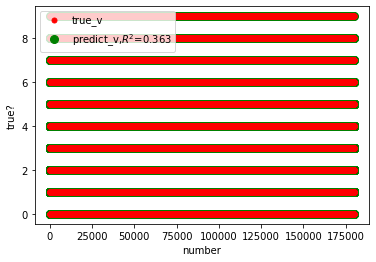

In [27]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train)):
    print("fold n°{}".format(fold_+1))
    x_train, y_train = X_train[trn_idx], Y_train[trn_idx]
    x_val, y_val = X_train[val_idx], Y_train[val_idx]
    
    lr = LogisticRegression()
    lr.fit(x_train, y_train)

    # 模型效果获取
    r = lr.score(x_train, y_train)
    print("R值(准确率):", r)
    # 预测
    y_predict = lr.predict(x_val)  # 预测
    print(y_predict)
    print(y_val)

    # 绘制测试集结果验证
    test_validate(x_test=x_val, y_test=y_val, y_predict=y_predict, classifier=lr)    
    break